In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import os
import cv2

In [3]:
train_data = ImageDataGenerator(rescale=1./255.0, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)\
.flow_from_directory(directory='data/Train',target_size=(100, 100), classes=['WithMask', 'WithoutMask'], batch_size=10)
valid_data = ImageDataGenerator(rescale=1./255.0, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)\
.flow_from_directory(directory='data/Validation',target_size=(100, 100), classes=['WithMask', 'WithoutMask'], batch_size=10)
test_data = ImageDataGenerator(rescale=1./255.0, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)\
.flow_from_directory(directory='data/Test',target_size=(100, 100), classes=['WithMask', 'WithoutMask'], batch_size=10, shuffle=False)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [5]:
imgs, labels = next(train_data)

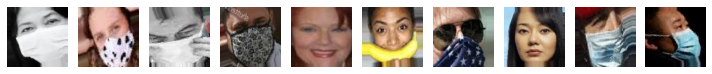

In [7]:
fig, ax = plt.subplots(1, 10, figsize=(10, 5))
ax =ax.flatten()
for img, ax in zip(imgs, ax):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [9]:
base_model = VGG16(input_shape = (100, 100, 3), include_top = False, weights = 'imagenet')

In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [11]:
base_model.trainable = False

In [12]:
model = Sequential()

In [13]:
model.add(base_model)
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(units=2, activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                147488    
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 14,862,242
Trainable params: 147,554
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
from tensorflow.keras.metrics import Accuracy

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(train_data, validation_data = valid_data, epochs = 20, verbose = 2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1000 steps, validate for 80 steps
Epoch 1/20
1000/1000 - 113s - loss: 0.0767 - accuracy: 0.9728 - val_loss: 0.0255 - val_accuracy: 0.9900
Epoch 2/20
1000/1000 - 35s - loss: 0.0538 - accuracy: 0.9832 - val_loss: 0.0381 - val_accuracy: 0.9862
Epoch 3/20
1000/1000 - 36s - loss: 0.0395 - accuracy: 0.9874 - val_loss: 0.0163 - val_accuracy: 0.9962
Epoch 4/20
1000/1000 - 37s - loss: 0.0331 - accuracy: 0.9907 - val_loss: 0.0203 - val_accuracy: 0.9925
Epoch 5/20
1000/1000 - 38s - loss: 0.0290 - accuracy: 0.9893 - val_loss: 0.0214 - val_accuracy: 0.9937
Epoch 6/20
1000/1000 - 38s - loss: 0.0323 - accuracy: 0.9898 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 7/20
1000/1000 - 37s - loss: 0.0214 - accuracy: 0.9920 - val_loss: 0.0255 - val_accuracy: 0.9937
Epoch 8/20
1000/1000 - 38s - loss: 0.0279 - accuracy: 0.9905 - val_loss: 0.0313 - val_accuracy: 0.9900
Epoch 9/20
1000/1000 - 38s - loss: 0.0204 - accuracy: 0.9922 - val_loss: 0.0117 -

In [19]:
from tensorflow.keras.models import save_model

In [20]:
save_model(model, filepath='My_model', save_format='h5')

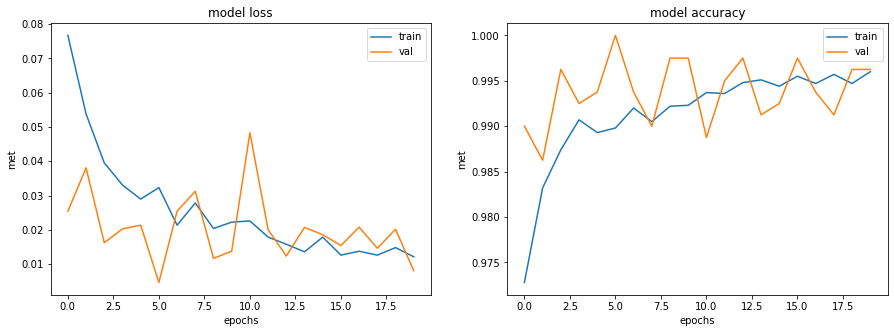

In [21]:
fig , ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.ravel()
for i, met in enumerate(['loss', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel('met')
    ax[i].legend(['train', 'val'])

In [22]:
face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
source = cv2.VideoCapture(0)
labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [24]:
while True:
    ret, img = source.read()
    faces = face_clsfr.detectMultiScale(img, 1.3, 5)
    for x,y,w,h in faces:
        face_img = img[y:y+w, x:x+w]
        resized = cv2.resize(face_img, (100, 100))
        normalized = resized/255.0
        reshaped = np.reshape(normalized, (1, 100, 100, 3))
        result = model.predict(reshaped)
    
        label = np.argmax(result, axis = 1)[0]
    
        cv2.rectangle(img, (x, y), (x+w, y+w), color_dict[label], 2)
        cv2.rectangle(img, (x, y-40), (x+w, y), color_dict[label], -1)
        cv2.putText(img, labels_dict[label], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    cv2.imshow('Live', img)
    key = cv2.waitKey(1)
    
    if key == ord('q'):
        break
cv2.destroyAllWindows()
source.release()

error: OpenCV(3.4.2) C:\Miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\highgui\src\window.cpp:356: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'
